## Image-Sweep

In [44]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import tensorflowjs as tfjs

## Data Augmentation

In [45]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal_and_vertical'),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.1),
    ])

## Split the data in training and validation dataset

In [46]:
directory = "data/"

BATCH_SIZE = 16
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=1,
                                                            validation_split=0.15,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=1,
                                                            validation_split=0.15,
                                                            subset = "validation")

Found 824 files belonging to 2 classes.
Using 701 files for training.
Found 824 files belonging to 2 classes.
Using 123 files for validation.


2024-06-08 11:52:27.028154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


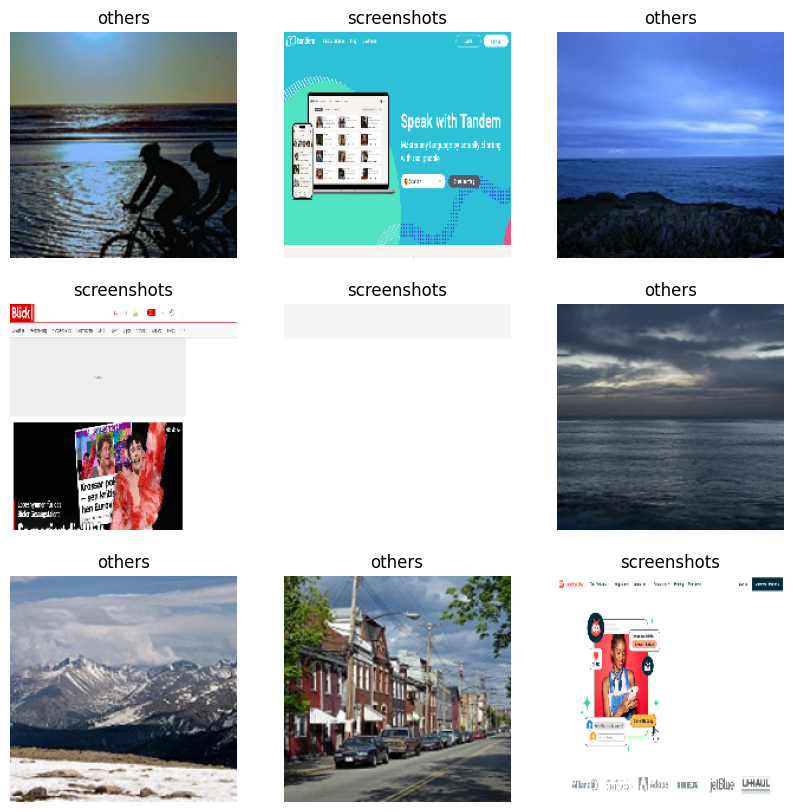

In [47]:
# This code is just plotting some of the training dataset in a grid
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [48]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 4)
validation_dataset = validation_dataset.skip(val_batches // 4)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 6
Number of test batches: 2


In [49]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [51]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [52]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-06-08 11:52:28.071471: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(16, 6, 6, 1280)


In [53]:
base_model.trainable = False

In [54]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [55]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_192            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [57]:
# Here the initial accuracy will be evaluated. This means we run an evaluation on the model 
# with the validation dataset before training the model. The purpose of this evaluation is to 
# get a baseline performance metric for the model, so we can compare it with the performance 
# after training to understand how much improvement has been achieved. The trained model should 
# be evaluated using the test dataset to ensure it generalizes well to unseen data.
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.3807 - loss: 0.8580
initial loss: 0.78
initial accuracy: 0.46


In [58]:
epochs = 25
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 316ms/step - accuracy: 0.5315 - loss: 0.7573 - val_accuracy: 0.7363 - val_loss: 0.5274
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.6350 - loss: 0.6305 - val_accuracy: 0.8022 - val_loss: 0.4727
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.6620 - loss: 0.6014 - val_accuracy: 0.8352 - val_loss: 0.4384
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 313ms/step - accuracy: 0.6550 - loss: 0.5806 - val_accuracy: 0.9011 - val_loss: 0.4018
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - accuracy: 0.7342 - loss: 0.5341 - val_accuracy: 0.9011 - val_loss: 0.3810
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 326ms/step - accuracy: 0.7566 - loss: 0.4944 - val_accuracy: 0.9451 - val_loss: 0.3473
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step - accuracy: 0.7754 - loss: 0.4708 - val_accuracy: 0.9670 - val_loss: 0.3334
Epoch 8/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.8013 - loss: 0.4278 - val_accu

In [65]:
model.save('models/model.keras')

# Interpretation and Validation

#### Training and Validation Accuracy
- **Training Accuracy**: The blue line represents the accuracy of the model on the training data. It shows a steady increase from around 0.4 to approximately 0.9, indicating that the model is learning and improving its performance on the training dataset.
- **Validation Accuracy**: The orange line represents the accuracy of the model on the validation data. It starts at around 0.45 and quickly increases to about 0.95, remaining relatively stable after the 10th epoch. This suggests that the model generalizes well to the unseen validation data initially but does not show further improvement after a certain point.

#### Training and Validation Loss
- **Training Loss**: The blue line shows the loss on the training data, which decreases steadily from 1.0 to below 0.2, indicating that the model is fitting the training data better over time.
- **Validation Loss**: The orange line represents the loss on the validation data. It decreases rapidly initially and then stabilizes around 0.1, indicating that the model is not overfitting and maintains a good generalization performance.

Overall, the model shows good learning behavior with increasing accuracy and decreasing loss for both training and validation datasets. The stable validation accuracy and low validation loss indicate that the model generalizes well and is not overfitting to the training data.


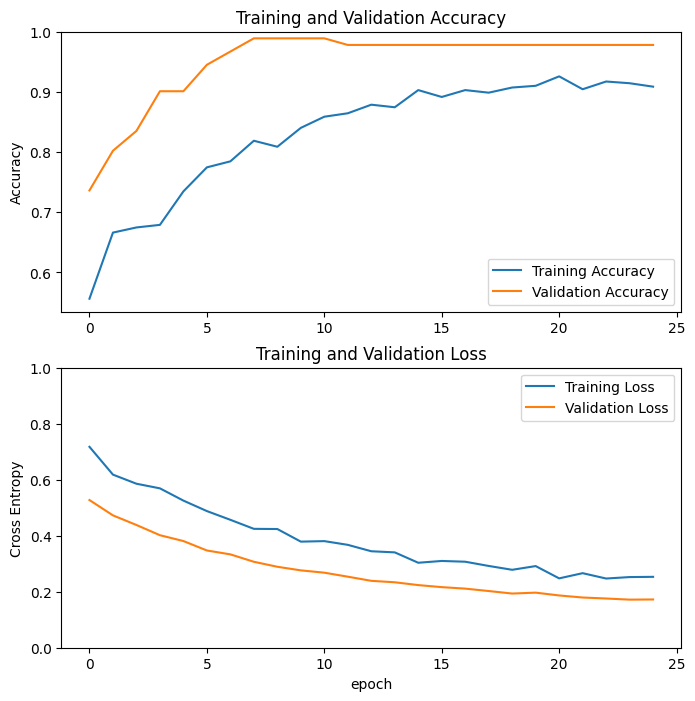

In [60]:
# This code will plot the Training and Validation Accuracy as well as the Training and Validation Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [61]:
# This is the evaluation on the test dataset which are pictures the model have never seen before.
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 1.0000 - loss: 0.2035
Test accuracy : 1.0


Predictions:
 [0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0]
Labels:
 [0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0]


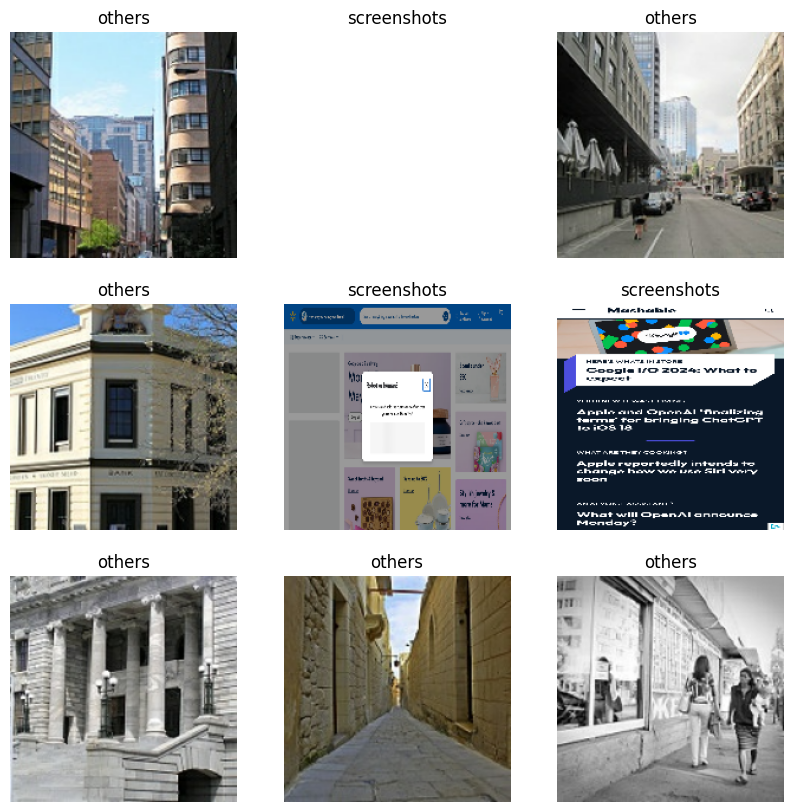

In [62]:
# This code shows the calssified test dataset in a grid with the label the model predicted
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch)

predicted_class_index = (predictions > 0.5).astype(int)

print('Predictions:\n', predicted_class_index.flatten())
print('Labels:\n', label_batch.flatten())

batch_size = image_batch.shape[0]
num_to_plot = min(batch_size, 9)
plt.figure(figsize=(10, 10))
for i in range(num_to_plot):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_class_index[i][0]])
    plt.axis("off")
plt.show()

# Try it out!

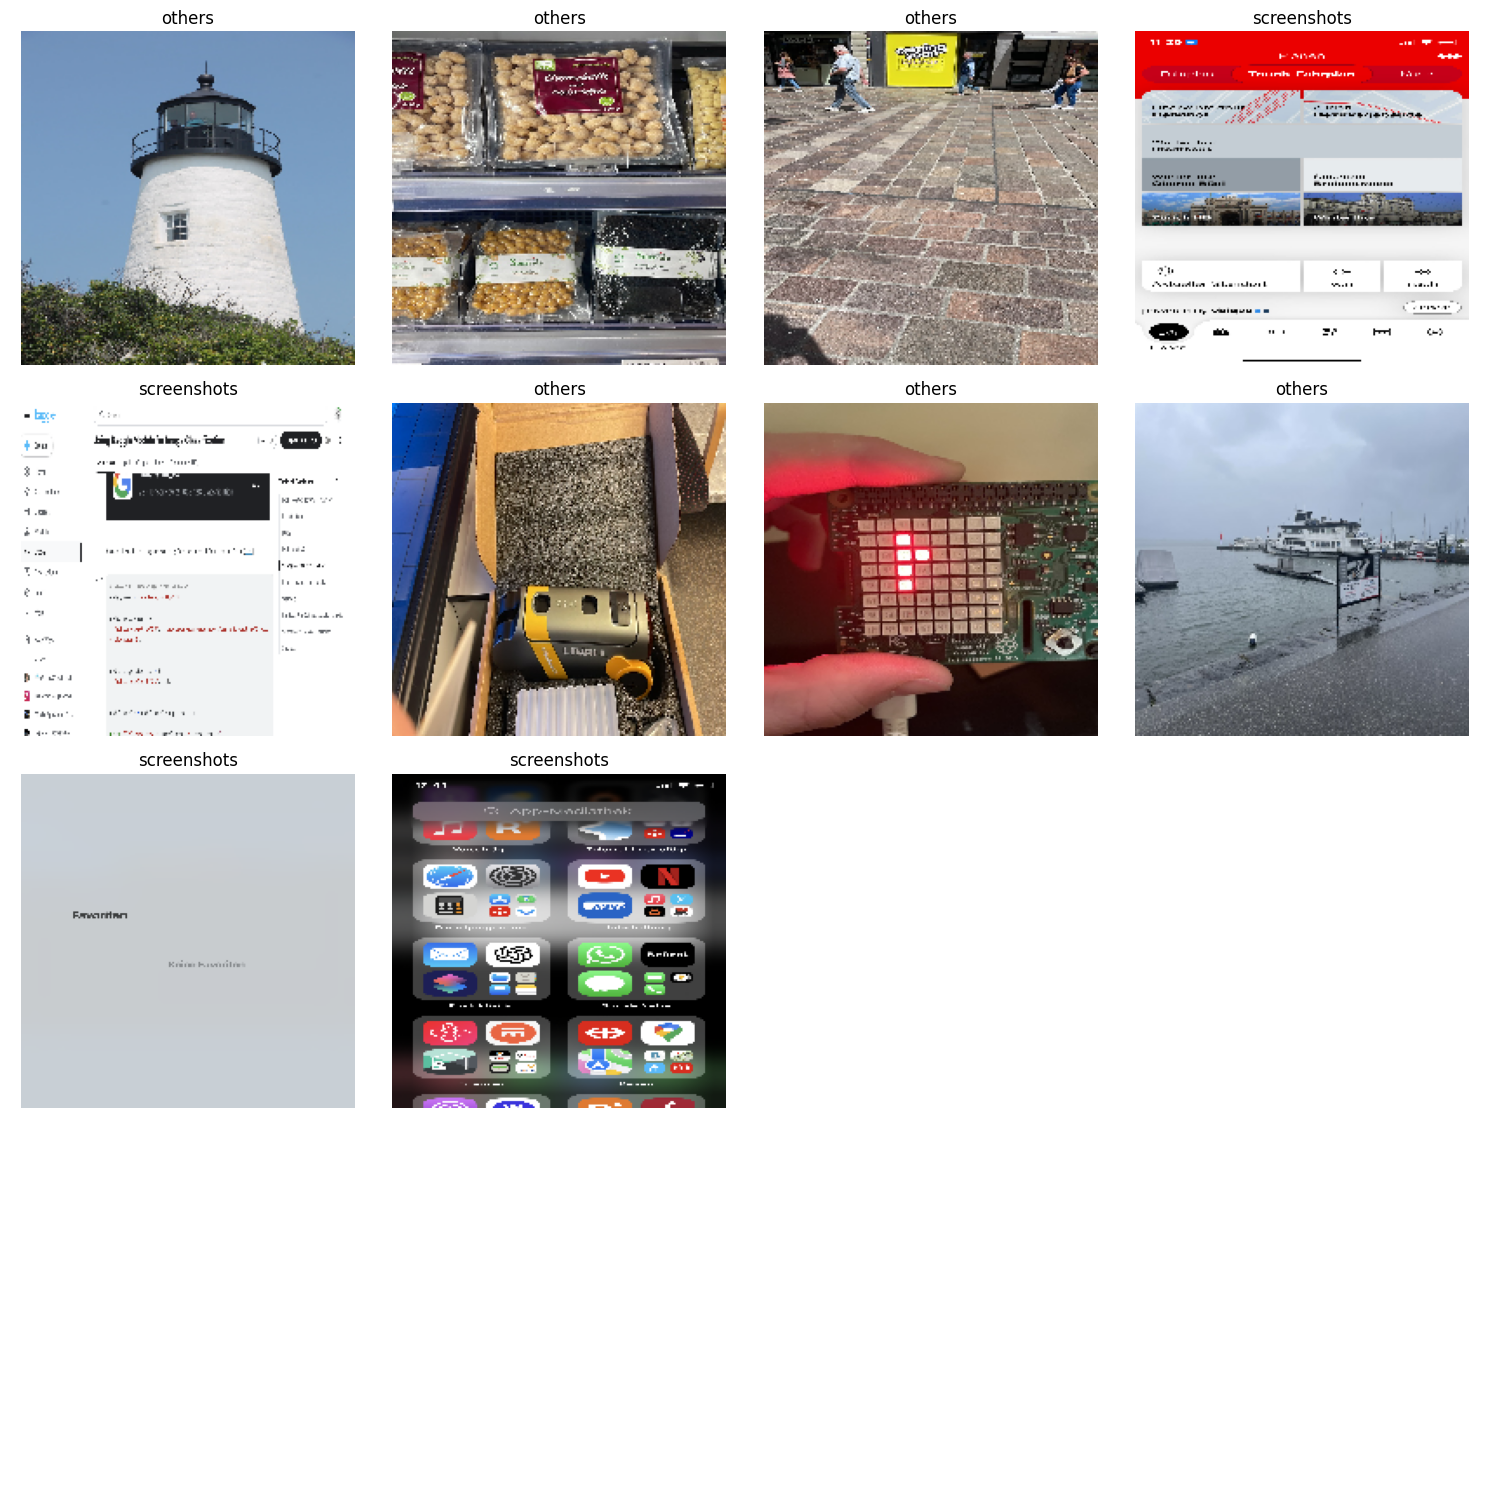

In [63]:
# This code snippet will clssify all pictures from the examples folder and show it with the predicted label in a Grid
import os
import tensorflow as tf
import matplotlib.pyplot as plt

directory = "examples/"

images = []
predictions = []

for filename in os.listdir(directory):
    img_path = os.path.join(directory, filename)
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        img = tf.keras.utils.load_img(img_path, target_size=(192, 192))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        prediction = model.predict_on_batch(img_array)
        predicted_class_index = (prediction > 0.5).astype(int)
        predicted_class = class_names[predicted_class_index[0][0]]
        images.append(img)
        predictions.append(predicted_class)

num_images = len(images)
grid_size = int(num_images**0.5) + 1

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, (img, prediction) in enumerate(zip(images, predictions)):
    axes[i].imshow(img)
    axes[i].set_title(prediction)
    axes[i].axis("off")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
